In [1]:
!pip install tensorflow
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl (332.0 MB)


C:\Users\subka\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\subka\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
C:\Users\subka\anaconda3\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in t

In [2]:
# Load the dataset
df = pd.read_csv('C:/Users/subka/Documents/AnacondaProjects/Phishing/dataset/phishing_site_urls.csv')

# Drop any potential duplicates or missing values
df = df.drop_duplicates()
df = df.dropna()

# Map labels to integers
df['Label'] = df['Label'].map({'good': 0, 'bad': 1})

# Separate URLs and Labels
urls = df['URL'].values
labels = df['Label'].values

print(f"Loaded {len(urls)} URLs.")

Loaded 507196 URLs.


In [3]:
# Create a character-level tokenizer
tokenizer = Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(urls)

# Convert URLs to sequences of integers
sequences = tokenizer.texts_to_sequences(urls)

# Determine vocabulary size (+1 for padding)
vocab_size = len(tokenizer.word_index) + 1
print(f"Vocabulary Size: {vocab_size}")

# Pad sequences to a fixed length for the model
max_length = 200 # A reasonable max length for URLs
X = pad_sequences(sequences, maxlen=max_length, padding='post')
y = np.array(labels)

print(f"Shape of data tensor (X): {X.shape}")
print(f"Shape of label tensor (y): {y.shape}")

Vocabulary Size: 232
Shape of data tensor (X): (507196, 200)
Shape of label tensor (y): (507196,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data successfully split into training and testing sets.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

Data successfully split into training and testing sets.
X_train shape: (405756, 200)
X_test shape: (101440, 200)


In [5]:
# Model Hyperparameters
embedding_dim = 64
filter_size = 128
kernel_size = 5

model = Sequential([
    # The Embedding layer turns character indices into dense vectors of a fixed size.
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    
    # Conv1D layer to learn local patterns of characters (n-grams)
    Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'),
    
    # GlobalMaxPooling1D reduces the feature maps to a single vector
    GlobalMaxPooling1D(),
    
    # A standard fully-connected layer
    Dense(128, activation='relu'),
    
    # Dropout layer to prevent overfitting
    Dropout(0.5),
    
    # Output layer with a sigmoid activation for binary classification (Phishing/Legitimate)
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

C:\Users\subka\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping to halt training when validation loss stops improving
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[early_stopping])

print("\nModel training complete.")

Epoch 1/20
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 534s 186ms/step - accuracy: 0.9452 - loss: 0.1498 - val_accuracy: 0.9632 - val_loss: 0.1077
Epoch 2/20
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 566s 187ms/step - accuracy: 0.9660 - loss: 0.0973 - val_accuracy: 0.9674 - val_loss: 0.0929
Epoch 3/20
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 543s 180ms/step - accuracy: 0.9701 - loss: 0.0852 - val_accuracy: 0.9711 - val_loss: 0.0813
Epoch 4/20
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 550s 193ms/step - accuracy: 0.9731 - loss: 0.0770 - val_accuracy: 0.9717 - val_loss: 0.0816
Epoch 5/20
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 518s 181ms/step - accuracy: 0.9746 - loss: 0.0722 - val_accuracy: 0.9697 - val_loss: 0.0869
Epoch 6/20
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 555s 179ms/step - accuracy: 0.9760 - loss: 0.0675 - val_accuracy: 0.9727 - val_loss: 0.0781
Epoch 7/20
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 567s 181ms/step - accuracy: 0.9772 - loss: 0.0640 - val_accuracy: 0.9617 - val_loss: 0.1058
Epoch 8/20
2853/2853 ━━━━━━━━━━━━━━━━━━━━ 546s 175ms/step - ac

3170/3170 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - accuracy: 0.9741 - loss: 0.0784
Test Accuracy: 97.41%
Test Loss: 0.0784
3170/3170 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step 

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.98      0.99      0.98     78580
    Phishing       0.95      0.93      0.94     22860

    accuracy                           0.97    101440
   macro avg       0.97      0.96      0.96    101440
weighted avg       0.97      0.97      0.97    101440


Confusion Matrix:


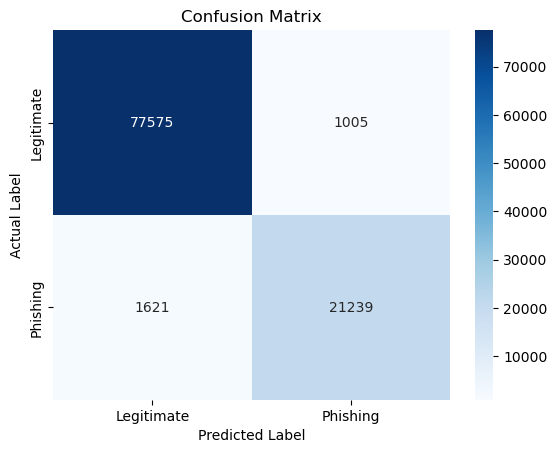

In [7]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Generate a detailed classification report
predictions_prob = model.predict(X_test)
predictions = (predictions_prob > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['Legitimate', 'Phishing']))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Phishing'], yticklabels=['Legitimate', 'Phishing'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()

In [8]:
# --- FINAL PREDICTION FUNCTION ---
def predict_url(url, model, tokenizer, max_length):
    # Process the single URL the same way as the training data
    seq = tokenizer.texts_to_sequences([url])
    padded_seq = pad_sequences(seq, maxlen=max_length, padding='post')
    
    # Get the model's prediction (a probability)
    prediction_prob = model.predict(padded_seq)[0][0]
    return prediction_prob

# --- TEST SUITE ---
urls_to_test = [
    "https://www.google.com",
    "https://www.youtube.com/watch?v=dQw4w9WgXcQ",
    "http://secure-login-apple-support.com-update.info/",
    "https://amazon.co.uk.security-update.net/verify/",
    "tinyurl.com/bswqloj",
    "http://192.168.1.1/login.html",
    "https://www.x.com",
    "https://login.nitrkl.ac.in/PortalMain",
    "https://abc.com"
]

# Set the confidence threshold
custom_threshold = 0.5

print(f"--- Running Final Model Tests with Threshold = {custom_threshold:.0%} ---")
for url in urls_to_test:
    confidence = predict_url(url, model, tokenizer, max_length)
    prediction = "Phishing" if confidence >= custom_threshold else "Legitimate"
    print(f"URL:        {url}")
    print(f"Prediction: {prediction} (Confidence of Phishing: {confidence:.2%})\\n")

--- Running Final Model Tests with Threshold = 50% ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
URL:        https://www.google.com
Prediction: Phishing (Confidence of Phishing: 99.99%)\n
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
URL:        https://www.youtube.com/watch?v=dQw4w9WgXcQ
Prediction: Legitimate (Confidence of Phishing: 35.02%)\n
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
URL:        http://secure-login-apple-support.com-update.info/
Prediction: Phishing (Confidence of Phishing: 100.00%)\n
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
URL:        https://amazon.co.uk.security-update.net/verify/
Prediction: Phishing (Confidence of Phishing: 100.00%)\n
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
URL:        tinyurl.com/bswqloj
Prediction: Phishing (Confidence of Phishing: 99.89%)\n
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
URL:        http://192.168.1.1/login.html
Prediction: Phishing (Confidence of Phishing: 100.00%)\n
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
URL:        https://www.x.com
Prediction: Phishi